In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
from tqdm import tqdm
import pickle
import torch
import cv2
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
G, color_edge = skeleton()
import src.procrustes as procrustes
import src.utils as utils

In [2]:
home_dir = '/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/'

experiments = ['vid_p6-0_off0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_on2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off3_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5']

leg_joints = ['RFbodyCoxa', 'RFfemurTibia', 'RFtibiaTarsus', 'RFclaw',
          'RMbodyCoxa', 'RMfemurTibia', 'RMtibiaTarsus', 'RMclaw',
          'RHbodyCoxa', 'RHfemurTibia', 'RHtibiaTarsus', 'RHclaw',
          'LFbodyCoxa', 'LFfemurTibia', 'LFtibiaTarsus', 'LFclaw', 
          'LMbodyCoxa', 'LMfemurTibia', 'LMtibiaTarsus', 'LMclaw',
          'LHbodyCoxa', 'LHfemurTibia', 'LHtibiaTarsus', 'LHclaw']

leg_tips = ['RFclaw', 'RMclaw', 'RHclaw', 'LFclaw', 'LMclaw', 'LHclaw']

ids = [1, 2, 3, 4,  6, 7, 8, 9,  11, 12, 13, 14,  16, 17, 18, 19,  21, 22, 23, 24,  26, 27, 28, 29]

Preprocess data

In [35]:
poses = []
X=None
for i in tqdm(range(len(experiments))):
    data = pd.read_hdf(home_dir + experiments[i]) #load data
    data = data.droplevel('scorer',axis=1) #drop scorer column label

    #rotate flies pointing left
    theta = np.radians(90)
    cos, sin = np.cos(theta), np.sin(theta)
    R = np.array(((cos, -sin), (sin, cos)))
    
    xy = data.loc[:,(slice(None),['x','y'])].to_numpy().copy() 
    n = xy.shape[1]
    xy = xy.reshape(-1,2)
    xy = np.matmul(xy - 68,R) + 68
    xy = xy.reshape(-1,n)
    
    data.loc[:,(slice(None),['x','y'])] = xy
    
    #select only leg joints
    data_np = data.loc[:,(leg_joints,['x','y'])].to_numpy()
    
    #save in DF3D format
    xy = np.stack((data_np[:,::2], data_np[:,1::2]), axis=2)
    poses.append(xy)
    print(home_dir + experiments[i])

100%|██████████| 7/7 [00:00<00:00, 42.69it/s]

/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_off0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_on0_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_off1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_on1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_off2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_on2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5
/data/LiftPose3D/fly_ventral_lowres/102906_s1a5_p6-0/vid_p6-0_off3_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5


In [54]:
template_dir = '/data/LiftPose3D/fly_ventral_lowres/network/'
body_coxas = [0,4,8,12,16,20]
prism_template = pickle.load(open(template_dir + '191125_PR_Fly1_001_prism.pkl','rb'))
prism_template = prism_template['points2d'][:,:,ids,:]
points2d = np.vstack(poses)

_, _, R,scale,t = procrustes.compute_similarity_transform(prism_template[0,:300,:,:].mean(axis=0)[body_coxas,:], \
                                                          points2d[50:200,body_coxas,:].mean(axis=0),\
                                                          compute_optimal_scale=True)

points2d_rescale = np.zeros_like(points2d)
for frame_idx in range(points2d.shape[0]):
    points2d_rescale[frame_idx,:,:] = 1.1*scale*np.dot(points2d[frame_idx,:,:], R) + t
    
pickle.dump({"points3d": points2d_rescale}, open(home_dir + '2d_pose_Fly0.pkl', 'wb'))

In [55]:
points2d.shape

(2399, 24, 2)

In [56]:
scale

3.588842957290359

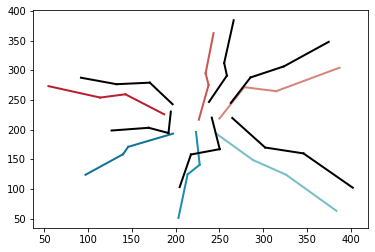

In [57]:
t = 5
template = np.zeros((prism_template.shape[1],len(G.nodes),2))
scaled = np.zeros((points2d_rescale.shape[0],len(G.nodes),2))
template[:,ids,:] = prism_template[0,:,:,:]
scaled[:,ids,:] = points2d_rescale
utils.plot_skeleton(G, template[t,:,0], template[t,:,1], color_edge)
utils.plot_skeleton(G, scaled[t,:,0], scaled[t,:,1])

Overlay DLC predictions with video

In [ ]:
imgs = utils.video_to_imgs(home_dir + '_'.join(experiments[1].split('_')[:4] + ['.mp4']))
data = pickle.load(open(home_dir + experiments[1][:-3] + '.pkl','rb'))

i = 40

plt.figure(figsize=(10,10))
im_rot = ndimage.rotate(imgs[i],90)
plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
utils.plot_skeleton(G,data[i,:,0], data[i,:,1], color_edge)
plt.axis('off')

DLC video

In [ ]:
#full image
fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
            
writer = FFMpegWriter(fps=10)
with writer.saving(fig, "DLC_prediction.mp4", 100):
    for exp in range(len(experiments)):
        imgs = utils.video_to_imgs(home_dir + '_'.join(experiments[exp].split('_')[:4] + ['.mp4']))
        data = pickle.load(open(home_dir + experiments[exp][:-3] + '.pkl','rb'))
        
        for i in tqdm(range(data.shape[0])):
            pos_pred, pos_tar = [], []   
            plt.cla()
        
            im_rot = ndimage.rotate(imgs[i],90)
            plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
                 
            utils.plot_skeleton(G,data[i,:,0],data[i,:,1], color_edge)
        
            plt.axis('off')
            writer.grab_frame() 

Arena video

In [ ]:
imgs = utils.video_to_imgs('arena.mp4')

Add circle around fly 0

In [ ]:
import cv2

count = 0
r = 70
thickness = 5
for i in range(len(experiments)):
    pos = np.load(home_dir + '_'.join(experiments[i].split('_')[:4] + ['.npy']))
    for j in range(pos.shape[0]):

        imgs[count] = cv2.circle(imgs[count], (int(pos[j,0]), int(pos[j,1])), r, (255, 255, 255), thickness) 
        count += 1
        
out = cv2.VideoWriter('arena_marked.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, (imgs[0].shape[0], imgs[0].shape[1]))
 
for i in range(len(imgs)):
    out.write(imgs[i])
out.release()

Check data after preprocessing

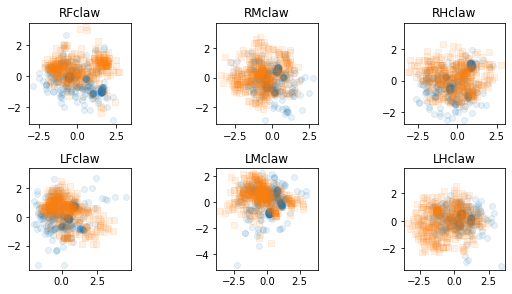

In [32]:
tint = [0,400]
times = np.arange(tint[0],tint[1])

template_dir = '/data/LiftPose3D/fly_ventral_lowres/network/'

poses = torch.load(home_dir + 'test_2d.pth.tar')
poses_template = torch.load(template_dir + 'train_2d.pth.tar')

poses = np.concatenate([v for k,v in poses.items()], 0)
poses_template = np.concatenate([v for k,v in poses_template.items()], 0)

poses = np.stack((poses[:,::2], poses[:,1::2]), axis=2)
poses_template = np.stack((poses_template[:,::2], poses_template[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

joint_id = [2, 5, 8, 11, 14, 17] #legtips
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(leg_tips[i])
    
    plt.plot(poses_template[times,k,0], poses_template[times,k,1],'o',alpha=0.1)  
    plt.plot(poses[times,k,0], poses[times,k,1],'s',alpha=0.1)
    plt.axis('square')
    
plt.tight_layout()
#plt.savefig('pose_distributions.svg')